In [203]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras import datasets, layers, models, regularizers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='D:/Flatiron/X-Ray_pneumonia__phase_4/data',
    batch_size=10000,
    seed=4356    
)

Found 5856 files belonging to 3 classes.


In [3]:
images, labels = next(iter(data))

In [4]:
images, labels = np.array(images), np.array(labels)

In [5]:
train_images, test_images, train_labels, test_labels = train_test_split(
    images,
    labels,
    random_state=42,
    test_size=585
)

In [6]:
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images,
    train_labels,
    random_state=42,
    test_size=585
)

In [7]:
train_images.shape

(4686, 256, 256, 3)

In [8]:
test_images.shape

(585, 256, 256, 3)

In [9]:
val_images.shape

(585, 256, 256, 3)

In [10]:
pd.DataFrame(train_labels).value_counts(normalize=True)

0    0.474392
1    0.265472
2    0.260137
dtype: float64

In [11]:
train_images, test_images, val_images = train_images/255, test_images/255, val_images/255

In [47]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

train_labels_encoded = ohe.fit_transform(train_labels.reshape(-1, 1)).toarray()

test_labels_encoded = ohe.fit_transform(test_labels.reshape(-1, 1)).toarray()

val_labels_encoded = ohe.fit_transform(val_labels.reshape(-1, 1)).toarray()

In [179]:
def evaluate(model, results, final=False):
    
    if final:
        val_label="test"
    else:
        val_label="validation"

    # Extracting metrics from model fitting
    train_loss = results.history['loss']
    val_loss = results.history['val_loss']
    train_accuracy = results.history['accuracy']
    val_accuracy = results.history['val_accuracy']

    # Setting up plots
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20, 10))

    # Plotting loss info
    ax1.set_title("Loss")
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label="train")
    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label=val_label)
    ax1.legend()

    # Plotting accuracy info
    ax2.set_title("Accuracy")
    sns.lineplot(x=results.epoch, y=train_accuracy, ax=ax2, label="train")
    sns.lineplot(x=results.epoch, y=val_accuracy, ax=ax2, label=val_label)
    ax2.legend()
    
    y_pred = model.predict(test_images)
    cm = confusion_matrix(test_labels, np.argmax(y_pred, axis=1))
    cm_df = pd.DataFrame(cm)

    sns.heatmap(cm, ax=ax3, annot=True, cmap='Blues', fmt='0.5g')

    label = ['Bacterial\n Accuracy',
             'Healthy\n Accuracy',
             'Viral\n Accuracy']

    height = [(cm_df[0][0]/sum(cm_df[0]))*100,
              (cm_df[1][1]/sum(cm_df[1]))*100,
              (cm_df[2][2]/sum(cm_df[2]))*100]

    ax4.bar(x=label, height=height)
    plt.sca(ax4)
    xlocs, xlabs = plt.xticks()
    plt.ylim(top=100)
    plt.ylabel('Accuracy Percentage')
    plt.title('Model Accuracy')
    for i, j in enumerate(height):
        ax4.text(xlocs[i],
                 j-30,
                 ((str(round(j,1)))+'%'),
                 ha ='center',
                 bbox = dict(facecolor = 'white', alpha = .5))
        
    cm_simple = [[cm_df[0][0]+cm_df[0][2]+cm_df[2][0]+cm_df[2][2], cm_df[1][0]+cm_df[1][2]],
                 [cm_df[0][1]+cm_df[2][1], cm_df[1][1]]]
    cm_simple_df = pd.DataFrame(cm_simple)
    
    sns.heatmap(cm_simple, ax=ax5, annot=True, cmap='Blues', fmt='0.5g')
    
    simple_label = ['Pneumonia\n Accuracy',
                    'Healthy\n Accuracy']
    
    simple_height = [(cm_simple_df[0][0]/sum(cm_simple_df[0]))*100,
                     (cm_simple_df[1][1]/sum(cm_simple_df[1]))*100]
    
    ax6.bar(x=simple_label, height=simple_height)
    plt.sca(ax6)
    xlocs, xlabs = plt.xticks()
    plt.ylim(top=100)
    plt.ylabel('Accuracy Percentage')
    plt.title('Model Accuracy')
    for k, l in enumerate(simple_height):
        ax6.text(xlocs[k],
                 l-30,
                 ((str(round(l,1)))+'%'),
                 ha ='center',
                 bbox = dict(facecolor = 'white', alpha = .5))

In [136]:
baseline = models.Sequential()

baseline.add(layers.Conv2D(filters=64,
                           kernel_size=2,
                           padding="same",
                           activation="relu",
                           input_shape=(256,256,3)))

baseline.add(layers.MaxPooling2D(pool_size=2))

baseline.add(layers.Conv2D(filters=32,
                           kernel_size=2,
                           padding="same",
                           activation ="relu"))
baseline.add(layers.MaxPooling2D(pool_size=2))
baseline.add(layers.Conv2D(filters=16,
                           kernel_size=2,
                           padding="same",
                           activation="relu"))
baseline.add(layers.MaxPooling2D(pool_size=2))

baseline.add(layers.Flatten())

baseline.add(layers.Dense(500,activation="relu"))

baseline.add(layers.Dense(3,activation="softmax"))

In [139]:
baseline.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

results = baseline.fit(
    train_images, 
    train_labels_encoded,
    validation_data=(val_images, val_labels_encoded),
    epochs=10,
    batch_size=128)

Epoch 1/10
37/37 [==============================] - 78s 2s/step - loss: 0.5792 - accuracy: 0.7493 - val_loss: 0.4680 - val_accuracy: 0.7897
Epoch 2/10
37/37 [==============================] - 78s 2s/step - loss: 0.4953 - accuracy: 0.7855 - val_loss: 0.4424 - val_accuracy: 0.8137
Epoch 3/10
37/37 [==============================] - 78s 2s/step - loss: 0.4644 - accuracy: 0.7996 - val_loss: 0.4186 - val_accuracy: 0.8120
Epoch 4/10
37/37 [==============================] - 78s 2s/step - loss: 0.4568 - accuracy: 0.8060 - val_loss: 0.4308 - val_accuracy: 0.8120
Epoch 5/10
37/37 [==============================] - 78s 2s/step - loss: 0.4246 - accuracy: 0.8169 - val_loss: 0.4394 - val_accuracy: 0.8137
Epoch 6/10
37/37 [==============================] - 78s 2s/step - loss: 0.3964 - accuracy: 0.8278 - val_loss: 0.4233 - val_accuracy: 0.8171
Epoch 7/10
37/37 [==============================] - 77s 2s/step - loss: 0.3695 - accuracy: 0.8389 - val_loss: 0.4314 - val_accuracy: 0.8103
Epoch 8/10
37/37 [==

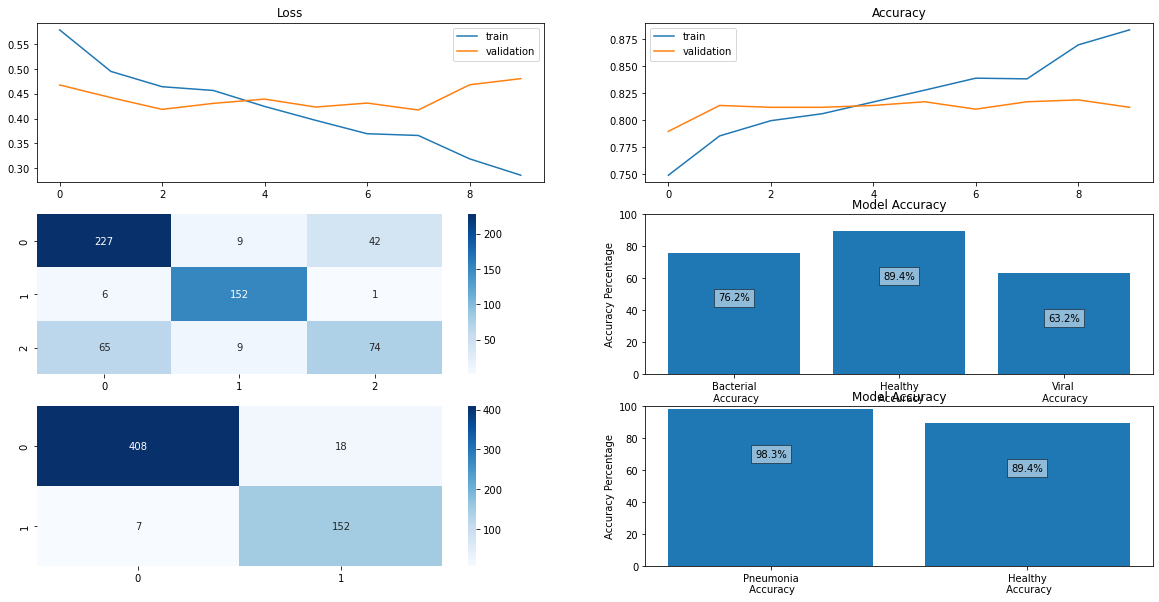

In [181]:
evaluate(baseline, results)

In [182]:
model2 = models.Sequential()

model2.add(layers.Conv2D(filters=64,
                         kernel_size=2,
                         padding="same",
                         activation="relu",
                         input_shape=(256,256,3)))

model2.add(layers.MaxPooling2D(pool_size=2))

model2.add(layers.Conv2D(32,
                         3,
                         padding="same",
                         activation ="relu"))
model2.add(layers.MaxPooling2D(pool_size=2))
model2.add(layers.Conv2D(16,
                         3,
                         padding="same",
                         activation="relu"))
model2.add(layers.MaxPooling2D(pool_size=2))

model2.add(layers.Flatten())

model2.add(layers.Dense(128,activation="relu"))
model2.add(layers.Dense(64,activation="relu"))
model2.add(layers.Dense(3,activation="softmax"))

In [183]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

In [184]:
results = model2.fit(
    train_images, 
    train_labels_encoded,
    validation_data=(val_images, val_labels_encoded),
    epochs=10,
    batch_size=128)

Epoch 1/10
37/37 [==============================] - 96s 3s/step - loss: 0.8717 - accuracy: 0.6116 - val_loss: 0.6093 - val_accuracy: 0.7282
Epoch 2/10
37/37 [==============================] - 96s 3s/step - loss: 0.5788 - accuracy: 0.7535 - val_loss: 0.4967 - val_accuracy: 0.7949
Epoch 3/10
37/37 [==============================] - 97s 3s/step - loss: 0.5132 - accuracy: 0.7796 - val_loss: 0.4643 - val_accuracy: 0.7983
Epoch 4/10
37/37 [==============================] - 96s 3s/step - loss: 0.4691 - accuracy: 0.7932 - val_loss: 0.4298 - val_accuracy: 0.8188
Epoch 5/10
37/37 [==============================] - 95s 3s/step - loss: 0.4487 - accuracy: 0.8054 - val_loss: 0.4272 - val_accuracy: 0.8256
Epoch 6/10
37/37 [==============================] - 95s 3s/step - loss: 0.4232 - accuracy: 0.8188 - val_loss: 0.4051 - val_accuracy: 0.8274
Epoch 7/10
37/37 [==============================] - 95s 3s/step - loss: 0.3952 - accuracy: 0.8265 - val_loss: 0.4425 - val_accuracy: 0.8103
Epoch 8/10
37/37 [==

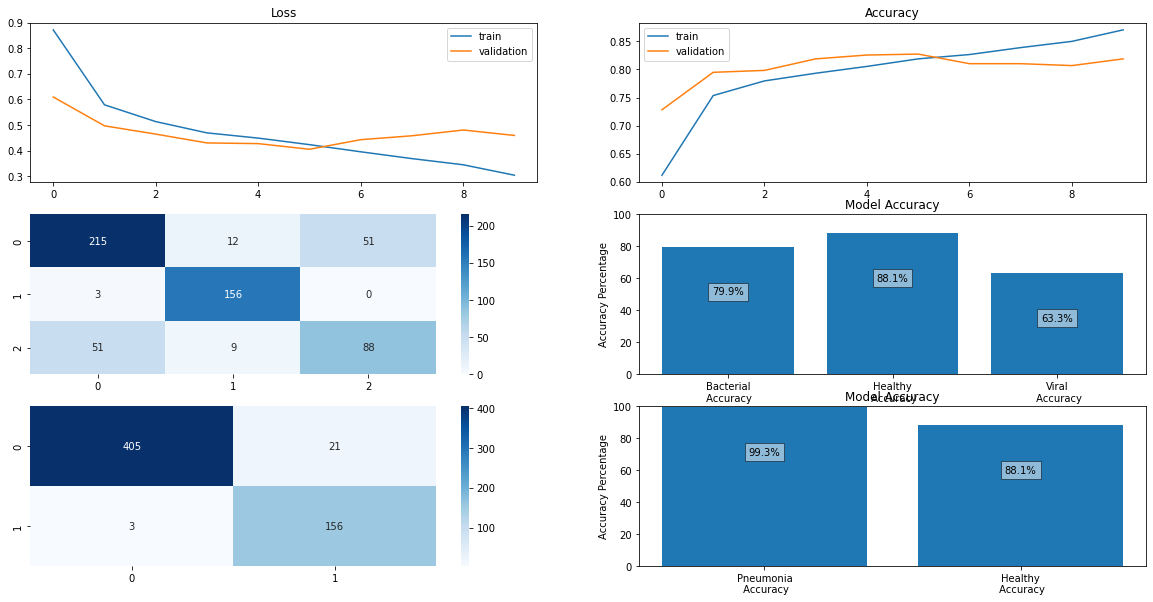

In [186]:
evaluate(model2, results)

In [187]:
model3 = models.Sequential()

model3.add(layers.Conv2D(filters=64,
                        kernel_size=3,
                        activation="relu",
                        input_shape=(256,256,3)))

model3.add(layers.MaxPooling2D(pool_size=2))

model3.add(layers.Conv2D(filters=32,
                        kernel_size=2,
                        padding="same",
                        activation ="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model3.add(layers.Conv2D(filters=16,
                        kernel_size=2,
                        padding="same",
                        activation ="relu"))
model3.add(layers.MaxPooling2D(pool_size=2))
model3.add(layers.Conv2D(filters=16,
                        kernel_size=2,
                        padding="same",
                        activation="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model3.add(layers.Conv2D(filters=8,
                        kernel_size=2,
                        padding="same",
                        activation="relu"))
model3.add(layers.MaxPooling2D(pool_size=2))

model3.add(layers.Flatten())

model3.add(layers.Dense(64,activation="relu"))
model3.add(layers.Dense(32,activation="relu"))
model3.add(layers.Dense(16,activation="relu"))
model3.add(layers.Dense(3,activation="softmax"))

In [188]:
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

In [189]:
results = model3.fit(
    train_images, 
    train_labels_encoded,
    validation_data=(val_images, val_labels_encoded),
    epochs=10,
    batch_size=128)

Epoch 1/10
37/37 [==============================] - 85s 2s/step - loss: 3.0707 - accuracy: 0.4895 - val_loss: 2.1733 - val_accuracy: 0.6581
Epoch 2/10
37/37 [==============================] - 84s 2s/step - loss: 1.6790 - accuracy: 0.6869 - val_loss: 1.2269 - val_accuracy: 0.7521
Epoch 3/10
37/37 [==============================] - 83s 2s/step - loss: 1.1183 - accuracy: 0.7443 - val_loss: 0.9053 - val_accuracy: 0.8017
Epoch 4/10
37/37 [==============================] - 83s 2s/step - loss: 0.8607 - accuracy: 0.7659 - val_loss: 0.7334 - val_accuracy: 0.7966
Epoch 5/10
37/37 [==============================] - 83s 2s/step - loss: 0.7261 - accuracy: 0.7836 - val_loss: 0.6513 - val_accuracy: 0.8085
Epoch 6/10
37/37 [==============================] - 83s 2s/step - loss: 0.6590 - accuracy: 0.7781 - val_loss: 0.5721 - val_accuracy: 0.8239
Epoch 7/10
37/37 [==============================] - 83s 2s/step - loss: 0.6158 - accuracy: 0.7896 - val_loss: 0.5460 - val_accuracy: 0.8120
Epoch 8/10
37/37 [==

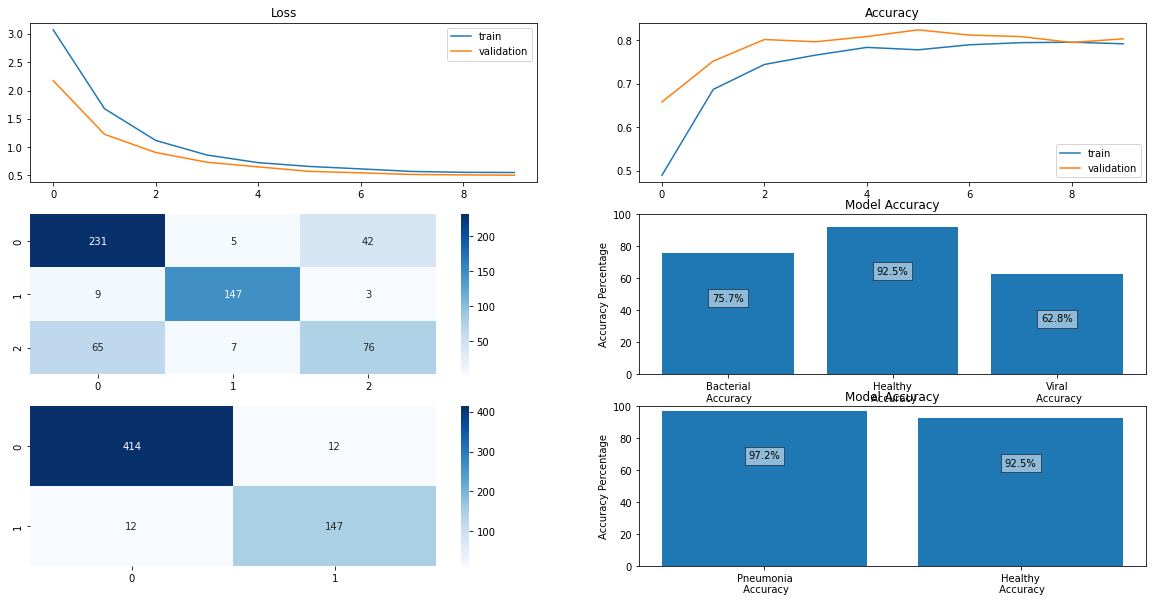

In [190]:
evaluate(model3, results)

In [194]:
model3b = models.Sequential()

model3b.add(layers.Conv2D(filters=64,
                        kernel_size=3,
                        activation="relu",
                        input_shape=(256,256,3)))

model3b.add(layers.MaxPooling2D(pool_size=2))

model3b.add(layers.Conv2D(filters=32,
                        kernel_size=2,
                        padding="same",
                        activation ="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model3b.add(layers.Conv2D(filters=16,
                        kernel_size=2,
                        padding="same",
                        activation ="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model3b.add(layers.MaxPooling2D(pool_size=2))

model3b.add(layers.Dropout(0.25))

model3b.add(layers.Conv2D(filters=16,
                        kernel_size=2,
                        padding="same",
                        activation="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model3b.add(layers.Conv2D(filters=8,
                        kernel_size=2,
                        padding="same",
                        activation="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model3b.add(layers.MaxPooling2D(pool_size=2))

model3b.add(layers.Dropout(0.25))

model3b.add(layers.Flatten())

model3b.add(layers.Dense(64,activation="relu"))
model3b.add(layers.Dense(32,activation="relu"))
model3b.add(layers.Dense(16,activation="relu"))
model3b.add(layers.Dense(3,activation="softmax"))

In [195]:
model3b.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

In [196]:
results = model3b.fit(
    train_images, 
    train_labels_encoded,
    validation_data=(val_images, val_labels_encoded),
    epochs=10,
    batch_size=128)

Epoch 1/10
37/37 [==============================] - 87s 2s/step - loss: 4.3180 - accuracy: 0.4902 - val_loss: 3.0721 - val_accuracy: 0.6496
Epoch 2/10
37/37 [==============================] - 86s 2s/step - loss: 2.3620 - accuracy: 0.6822 - val_loss: 1.8082 - val_accuracy: 0.7248
Epoch 3/10
37/37 [==============================] - 85s 2s/step - loss: 1.4660 - accuracy: 0.7328 - val_loss: 1.1788 - val_accuracy: 0.7590
Epoch 4/10
37/37 [==============================] - 86s 2s/step - loss: 1.1089 - accuracy: 0.7128 - val_loss: 0.9355 - val_accuracy: 0.7863
Epoch 5/10
37/37 [==============================] - 85s 2s/step - loss: 0.8979 - accuracy: 0.7390 - val_loss: 0.7394 - val_accuracy: 0.7761
Epoch 6/10
37/37 [==============================] - 85s 2s/step - loss: 0.7686 - accuracy: 0.7514 - val_loss: 0.6590 - val_accuracy: 0.7812
Epoch 7/10
37/37 [==============================] - 85s 2s/step - loss: 0.7021 - accuracy: 0.7518 - val_loss: 0.6085 - val_accuracy: 0.7915
Epoch 8/10
37/37 [==

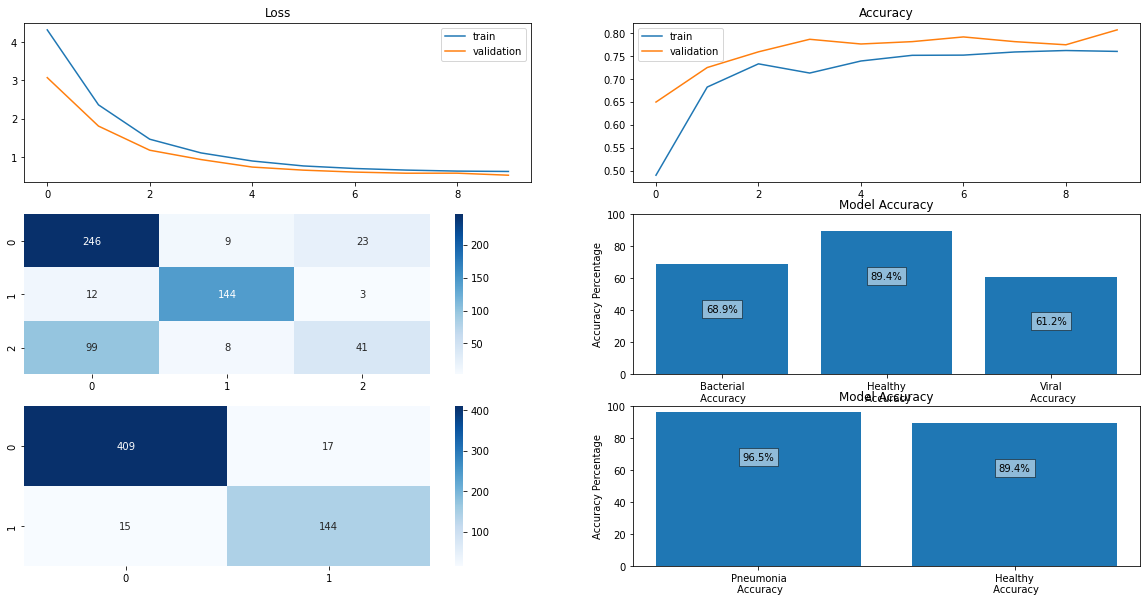

In [197]:
evaluate(model3b, results)

In [198]:
model4 = models.Sequential()

model4.add(layers.Conv2D(filters=64,
                        kernel_size=3,
                        activation="relu",
                        input_shape=(256,256,3)))

model4.add(layers.MaxPooling2D(pool_size=2))

model4.add(layers.Conv2D(filters=32,
                        kernel_size=3,
                        padding="same",
                        activation ="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model4.add(layers.Conv2D(filters=16,
                        kernel_size=2,
                        padding="same",
                        activation ="relu"))
model4.add(layers.MaxPooling2D(pool_size=2))

model4.add(layers.Dropout(0.25))

model4.add(layers.Conv2D(filters=16,
                        kernel_size=3,
                        padding="same",
                        activation="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model4.add(layers.Conv2D(filters=8,
                        kernel_size=2,
                        padding="same",
                        activation="relu"))
model4.add(layers.MaxPooling2D(pool_size=2))

model4.add(layers.Flatten())

model4.add(layers.Dense(128,activation="relu"))
model4.add(layers.Dense(64,activation="relu"))
model4.add(layers.Dense(32,activation="relu"))
model4.add(layers.Dense(16,activation="relu"))
model4.add(layers.Dense(3,activation="softmax"))

In [199]:
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

In [200]:
results = model4.fit(
    train_images, 
    train_labels_encoded,
    validation_data=(val_images, val_labels_encoded),
    epochs=10,
    batch_size=128)

Epoch 1/10
37/37 [==============================] - 105s 3s/step - loss: 2.7141 - accuracy: 0.5715 - val_loss: 1.7551 - val_accuracy: 0.6256
Epoch 2/10
37/37 [==============================] - 104s 3s/step - loss: 1.2792 - accuracy: 0.6869 - val_loss: 0.8809 - val_accuracy: 0.7778
Epoch 3/10
37/37 [==============================] - 104s 3s/step - loss: 0.8732 - accuracy: 0.7290 - val_loss: 0.8215 - val_accuracy: 0.7590
Epoch 4/10
37/37 [==============================] - 105s 3s/step - loss: 0.7087 - accuracy: 0.7561 - val_loss: 0.6016 - val_accuracy: 0.8171
Epoch 5/10
37/37 [==============================] - 104s 3s/step - loss: 0.6305 - accuracy: 0.7697 - val_loss: 0.5428 - val_accuracy: 0.8171
Epoch 6/10
37/37 [==============================] - 104s 3s/step - loss: 0.6026 - accuracy: 0.7740 - val_loss: 0.5034 - val_accuracy: 0.8188
Epoch 7/10
37/37 [==============================] - 105s 3s/step - loss: 0.5640 - accuracy: 0.7866 - val_loss: 0.5309 - val_accuracy: 0.8325
Epoch 8/10
37

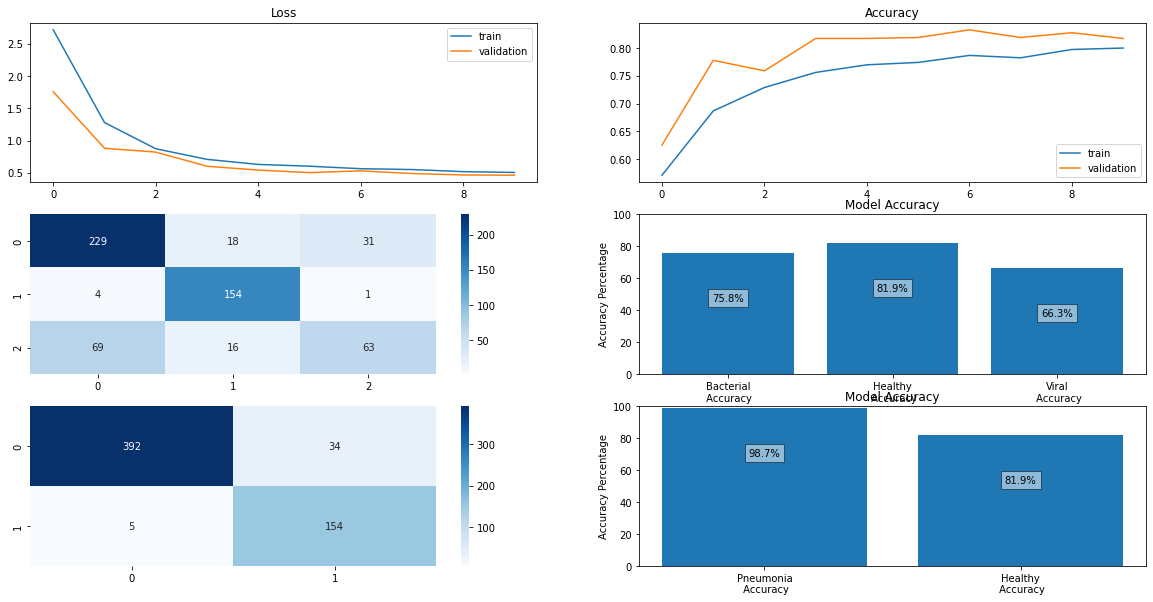

In [201]:
evaluate(model4, results)

In [211]:
model4b = models.Sequential()

model4b.add(layers.Conv2D(filters=64,
                        kernel_size=3,
                        activation="relu",
                        input_shape=(256,256,3)))

model4b.add(layers.MaxPooling2D(pool_size=2))

model4b.add(layers.Conv2D(filters=32,
                        kernel_size=3,
                        padding="same",
                        activation ="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model4b.add(layers.Conv2D(filters=16,
                        kernel_size=2,
                        padding="same",
                        activation ="relu"))
model4b.add(layers.MaxPooling2D(pool_size=2))

model4b.add(layers.Dropout(0.25))

model4b.add(layers.Conv2D(filters=16,
                        kernel_size=3,
                        padding="same",
                        activation="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model4b.add(layers.Conv2D(filters=8,
                        kernel_size=2,
                        padding="same",
                        activation="relu"))
model4b.add(layers.MaxPooling2D(pool_size=2))

model4b.add(layers.Flatten())

model4b.add(layers.Dense(128,activation="relu"))
model4b.add(layers.Dense(64,activation="relu"))
model4b.add(layers.Dense(32,activation="relu"))
model4b.add(layers.Dense(16,activation="relu"))
model4b.add(layers.Dense(3,activation="softmax"))

In [212]:
model4b.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

In [213]:
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=1e-8,
                           verbose=1,
                           mode='min',
                           patience=5)

In [214]:
results = model4b.fit(
    train_images, 
    train_labels_encoded,
    validation_data=(val_images, val_labels_encoded),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop]
)

Epoch 1/50
37/37 [==============================] - 106s 3s/step - loss: 2.7227 - accuracy: 0.5062 - val_loss: 1.7603 - val_accuracy: 0.6479
Epoch 2/50
37/37 [==============================] - 107s 3s/step - loss: 1.2819 - accuracy: 0.7029 - val_loss: 0.9244 - val_accuracy: 0.7915
Epoch 3/50
37/37 [==============================] - 106s 3s/step - loss: 0.8416 - accuracy: 0.7580 - val_loss: 0.6747 - val_accuracy: 0.8325
Epoch 4/50
37/37 [==============================] - 105s 3s/step - loss: 0.8128 - accuracy: 0.7143 - val_loss: 0.9957 - val_accuracy: 0.5966
Epoch 5/50
37/37 [==============================] - 104s 3s/step - loss: 0.8363 - accuracy: 0.7044 - val_loss: 0.6908 - val_accuracy: 0.7966
Epoch 6/50
37/37 [==============================] - 104s 3s/step - loss: 0.6979 - accuracy: 0.7465 - val_loss: 0.6065 - val_accuracy: 0.8068
Epoch 7/50
37/37 [==============================] - 104s 3s/step - loss: 0.6716 - accuracy: 0.7360 - val_loss: 0.5900 - val_accuracy: 0.7880
Epoch 8/50
37

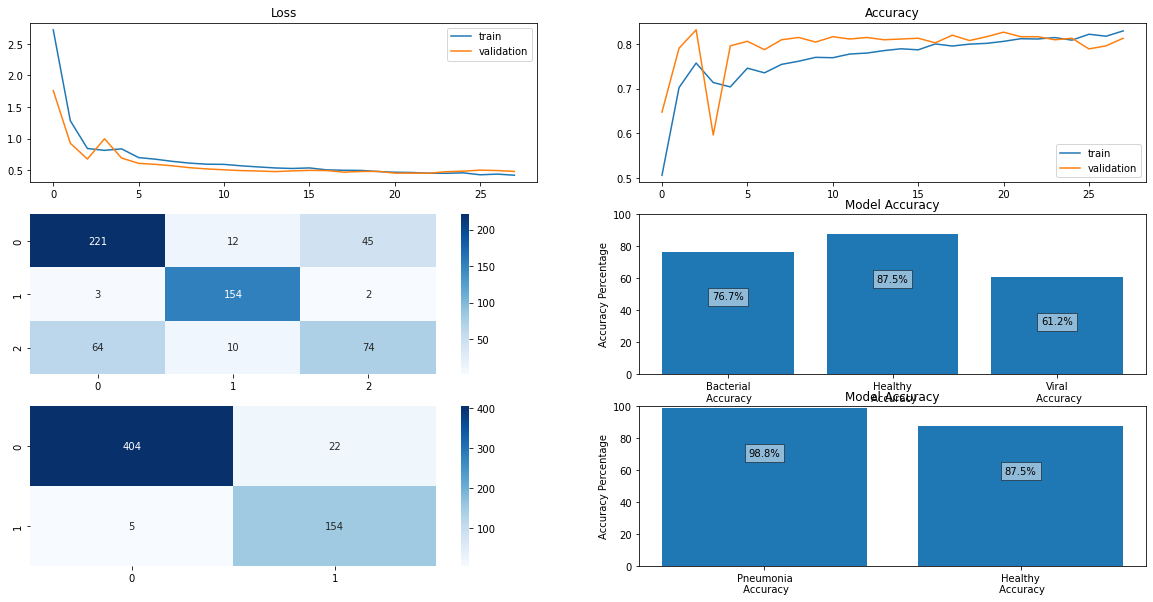

In [215]:
evaluate(model4b, results)

In [220]:
model4c = models.Sequential()

model4c.add(layers.Conv2D(filters=64,
                        kernel_size=3,
                        activation="relu",
                        input_shape=(256,256,3)))

model4c.add(layers.MaxPooling2D(pool_size=2))

model4c.add(layers.Conv2D(filters=32,
                        kernel_size=3,
                        padding="same",
                        activation ="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model4c.add(layers.Conv2D(filters=16,
                        kernel_size=2,
                        padding="same",
                        activation ="relu"))
model4c.add(layers.MaxPooling2D(pool_size=2))

model4c.add(layers.Conv2D(filters=16,
                        kernel_size=3,
                        padding="same",
                        activation="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
model4c.add(layers.Conv2D(filters=8,
                        kernel_size=2,
                        padding="same",
                        activation="relu"))
model4c.add(layers.MaxPooling2D(pool_size=2))

model4c.add(layers.Flatten())

model4c.add(layers.Dense(128,activation="relu"))
model4c.add(layers.Dense(64,activation="relu"))
model4c.add(layers.Dense(32,activation="relu"))
model4c.add(layers.Dense(16,activation="relu"))
model4c.add(layers.Dense(3,activation="softmax"))

In [221]:
model4c.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

In [222]:
results = model4c.fit(
    train_images, 
    train_labels_encoded,
    validation_data=(val_images, val_labels_encoded),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop]
)

Epoch 1/50
37/37 [==============================] - 107s 3s/step - loss: 2.7800 - accuracy: 0.5032 - val_loss: 2.0531 - val_accuracy: 0.4034
Epoch 2/50
37/37 [==============================] - 107s 3s/step - loss: 1.3035 - accuracy: 0.6769 - val_loss: 0.8589 - val_accuracy: 0.7607
Epoch 3/50
37/37 [==============================] - 106s 3s/step - loss: 0.8295 - accuracy: 0.7441 - val_loss: 0.7030 - val_accuracy: 0.7829
Epoch 4/50
37/37 [==============================] - 105s 3s/step - loss: 0.6903 - accuracy: 0.7640 - val_loss: 0.5841 - val_accuracy: 0.8103
Epoch 5/50
37/37 [==============================] - 103s 3s/step - loss: 0.6184 - accuracy: 0.7742 - val_loss: 0.5404 - val_accuracy: 0.8034
Epoch 6/50
37/37 [==============================] - 105s 3s/step - loss: 0.5867 - accuracy: 0.7840 - val_loss: 0.5279 - val_accuracy: 0.8068
Epoch 7/50
37/37 [==============================] - 106s 3s/step - loss: 0.5483 - accuracy: 0.7951 - val_loss: 0.5302 - val_accuracy: 0.7829
Epoch 8/50
37

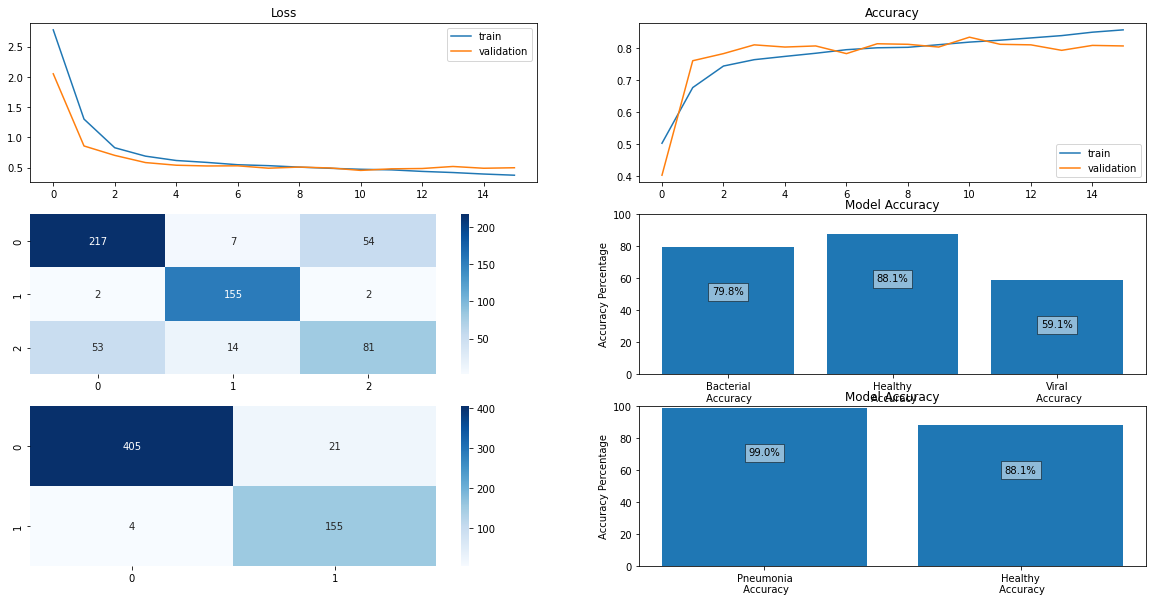

In [223]:
evaluate(model4c, results)

In [237]:
final_model = models.Sequential()

final_model.add(layers.Conv2D(filters=64,
                        kernel_size=3,
                        activation="relu",
                        input_shape=(256,256,3)))

final_model.add(layers.MaxPooling2D(pool_size=2))

final_model.add(layers.Conv2D(filters=32,
                        kernel_size=2,
                        padding="same",
                        activation ="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
final_model.add(layers.Conv2D(filters=16,
                        kernel_size=2,
                        padding="same",
                        activation ="relu"))
final_model.add(layers.MaxPooling2D(pool_size=2))
final_model.add(layers.Conv2D(filters=16,
                        kernel_size=2,
                        padding="same",
                        activation="relu",
                        kernel_regularizer=regularizers.L2(l=0.05)))
final_model.add(layers.Conv2D(filters=8,
                        kernel_size=2,
                        padding="same",
                        activation="relu"))
final_model.add(layers.MaxPooling2D(pool_size=2))

final_model.add(layers.Flatten())

final_model.add(layers.Dense(64,activation="relu"))
final_model.add(layers.Dense(32,activation="relu"))
final_model.add(layers.Dense(16,activation="relu"))
final_model.add(layers.Dense(3,activation="softmax"))

In [238]:
final_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

In [239]:
results = final_model.fit(
    train_images, 
    train_labels_encoded,
    validation_data=(val_images, val_labels_encoded),
    epochs=15,
    batch_size=128
)

Epoch 1/15
37/37 [==============================] - 85s 2s/step - loss: 3.0388 - accuracy: 0.5011 - val_loss: 2.1302 - val_accuracy: 0.6667
Epoch 2/15
37/37 [==============================] - 85s 2s/step - loss: 1.6702 - accuracy: 0.6912 - val_loss: 1.2062 - val_accuracy: 0.7624
Epoch 3/15
37/37 [==============================] - 85s 2s/step - loss: 1.1158 - accuracy: 0.7388 - val_loss: 0.9067 - val_accuracy: 0.7607
Epoch 4/15
37/37 [==============================] - 85s 2s/step - loss: 0.8774 - accuracy: 0.7578 - val_loss: 0.7438 - val_accuracy: 0.7778
Epoch 5/15
37/37 [==============================] - 85s 2s/step - loss: 0.7663 - accuracy: 0.7542 - val_loss: 0.6997 - val_accuracy: 0.7556
Epoch 6/15
37/37 [==============================] - 85s 2s/step - loss: 0.6941 - accuracy: 0.7729 - val_loss: 0.6075 - val_accuracy: 0.8188
Epoch 7/15
37/37 [==============================] - 85s 2s/step - loss: 0.6430 - accuracy: 0.7813 - val_loss: 0.5833 - val_accuracy: 0.8051
Epoch 8/15
37/37 [==

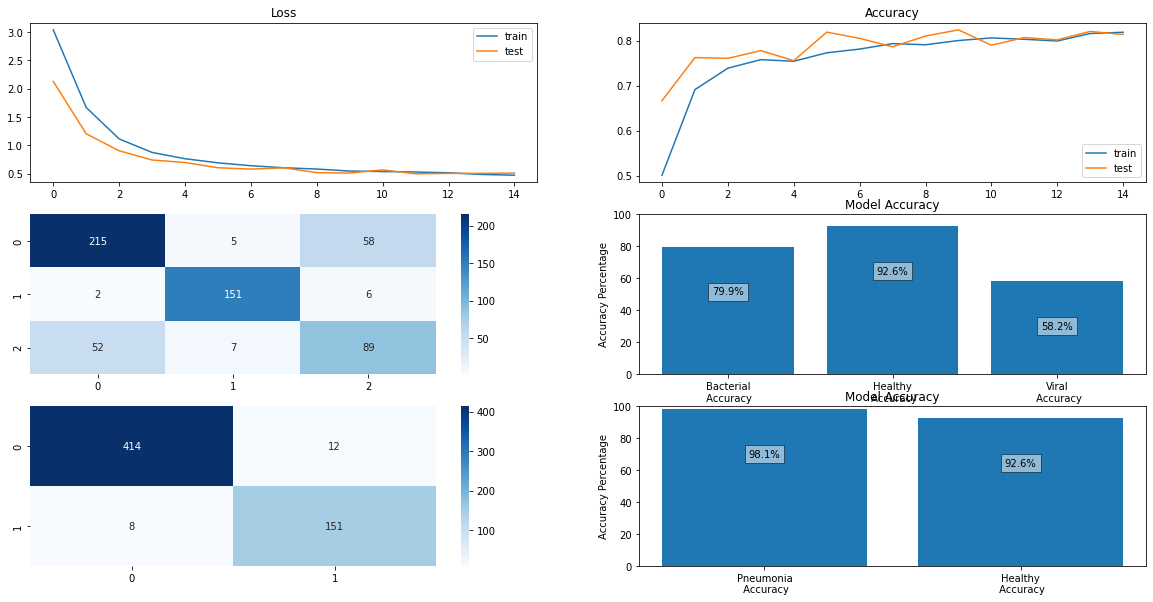

In [240]:
evaluate(final_model, results, final=True)